In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

from tqdm import tqdm
from sklearn.cluster import KMeans
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  GeForce GTX 1050 Ti, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
LABEL = 0

In [6]:
df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df['path'] = '../input/cassava-leaf-disease-classification/train_images/' + df['image_id']
df.head()

,image_id,label,path
0,1000015157.jpg,0,../input/cassava-leaf-disease-classification/t...
1,1000201771.jpg,3,../input/cassava-leaf-disease-classification/t...
2,100042118.jpg,1,../input/cassava-leaf-disease-classification/t...
3,1000723321.jpg,1,../input/cassava-leaf-disease-classification/t...
4,1000812911.jpg,3,../input/cassava-leaf-disease-classification/t...


In [48]:
nr_samples = int(df.label.value_counts().min() * SPLIT_RATIO)
        
df_val = []
for c in range(CLASSES):
    df_val.append(df[df['label']==c].sample(nr_samples))
df_val = pd.concat(df_val)
df_train = df[[d not in list(df_val['image_id']) for d in list(df['image_id'])]]

In [49]:
df_train

,image_id,label,path
0,1000015157.jpg,0,../input/cassava-leaf-disease-classification/t...
1,1000201771.jpg,3,../input/cassava-leaf-disease-classification/t...
2,100042118.jpg,1,../input/cassava-leaf-disease-classification/t...
3,1000723321.jpg,1,../input/cassava-leaf-disease-classification/t...
4,1000812911.jpg,3,../input/cassava-leaf-disease-classification/t...
...,...,...,...
21392,999068805.jpg,3,../input/cassava-leaf-disease-classification/t...
21393,999329392.jpg,3,../input/cassava-leaf-disease-classification/t...
21394,999474432.jpg,1,../input/cassava-leaf-disease-classification/t...
21395,999616605.jpg,4,../input/cassava-leaf-disease-classification/t...


In [76]:
nr_samples = int(df_train.label.value_counts().max())

dff = pd.DataFrame(columns=df.columns)
for c in range(CLASSES):
    df_class = df_train[df_train['label']==c]
    
    ratio = max(1, int(nr_samples/len(df_class)))
    for _ in range(ratio):
        dff = dff.append(df_class)

In [79]:
int(df_train.label.value_counts().max()/df_train.label.value_counts().min())

14

In [63]:
nr_samples = int(df_train.label.value_counts().min())

dff = pd.DataFrame(columns=df.columns)
it = 0
while not np.isin(np.unique(list(df_train['path'])), np.unique(list(dff['path']))).all() or it<1000:
    df_epoch = pd.DataFrame(columns=df.columns)
    for c in range(CLASSES):
        df_epoch = df_epoch.append(df_train[df_train['label']==c].sample(nr_samples), ignore_index=True)
    df_epoch = df_epoch.sample(frac=1)
    
    dff = dff.append(df_epoch)
    
    it += 1

dff

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Users\lucas\anaconda3\envs\kaggle-cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-63-fc07233ca007>", line 5, in <module>
    while not np.isin(np.unique(list(df_train['path'])), np.unique(list(dff['path']))).all() or it<1000:
  File "<__array_function__ internals>", line 6, in unique
  File "D:\Users\lucas\anaconda3\envs\kaggle-cassava\lib\site-packages\numpy\lib\arraysetops.py", line 262, in unique
    ret = _unique1d(ar, return_index, return_inverse, return_counts)
  File "D:\Users\lucas\anaconda3\envs\kaggle-cassava\lib\site-packages\numpy\lib\arraysetops.py", line 310, in _unique1d
    ar.sort()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Users\lucas\anaconda3\envs\kaggle-cassava\lib\site-packages\IPython\core\interactiveshell.py", line 

TypeError: object of type 'NoneType' has no len()

In [65]:
dff

,image_id,label,path
3251,2245122329.jpg,3,../input/cassava-leaf-disease-classification/t...
855,1463935986.jpg,0,../input/cassava-leaf-disease-classification/t...
3248,3901047977.jpg,3,../input/cassava-leaf-disease-classification/t...
342,2642869227.jpg,0,../input/cassava-leaf-disease-classification/t...
872,2564891184.jpg,1,../input/cassava-leaf-disease-classification/t...
...,...,...,...
175,2746592170.jpg,0,../input/cassava-leaf-disease-classification/t...
4227,884612746.jpg,4,../input/cassava-leaf-disease-classification/t...
3432,2219335308.jpg,3,../input/cassava-leaf-disease-classification/t...
35,2881921977.jpg,0,../input/cassava-leaf-disease-classification/t...


In [5]:
feat_extractor = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=INPUT_SHAPE,
    pooling='avg'
)

In [6]:
def get_features(label, name):
    
    path = f'{name}_{label}.npy'
    
    if os.path.exists(path):
        print('Loaded saved features...')
        return np.load(path)
    
    print('Calculating features...')
    feats = []
    for _,row in tqdm(df.iterrows(), total=len(df)):
        if row['label']!=label:
            continue
        
        img = imread(row['path'], resize=INPUT_SHAPE[:2])
        img = preprocess_input(img)

        feats.extend(feat_extractor(img[np.newaxis,...]))
        
    feats = np.float32(feats)
    np.save(path, feats)
    return feats

In [7]:
features = {}
for i in range(6):
    features[i] = get_features(i, 'features')

Loaded saved features...
Loaded saved features...
Loaded saved features...
Loaded saved features...
Loaded saved features...
Loaded saved features...


In [19]:
pred = KMeans(n_clusters=3, random_state=SEED).fit_predict(features[3])

In [20]:
len(pred[pred==0]), len(pred[pred==1]), len(pred[pred==2])

(5392, 5129, 2637)

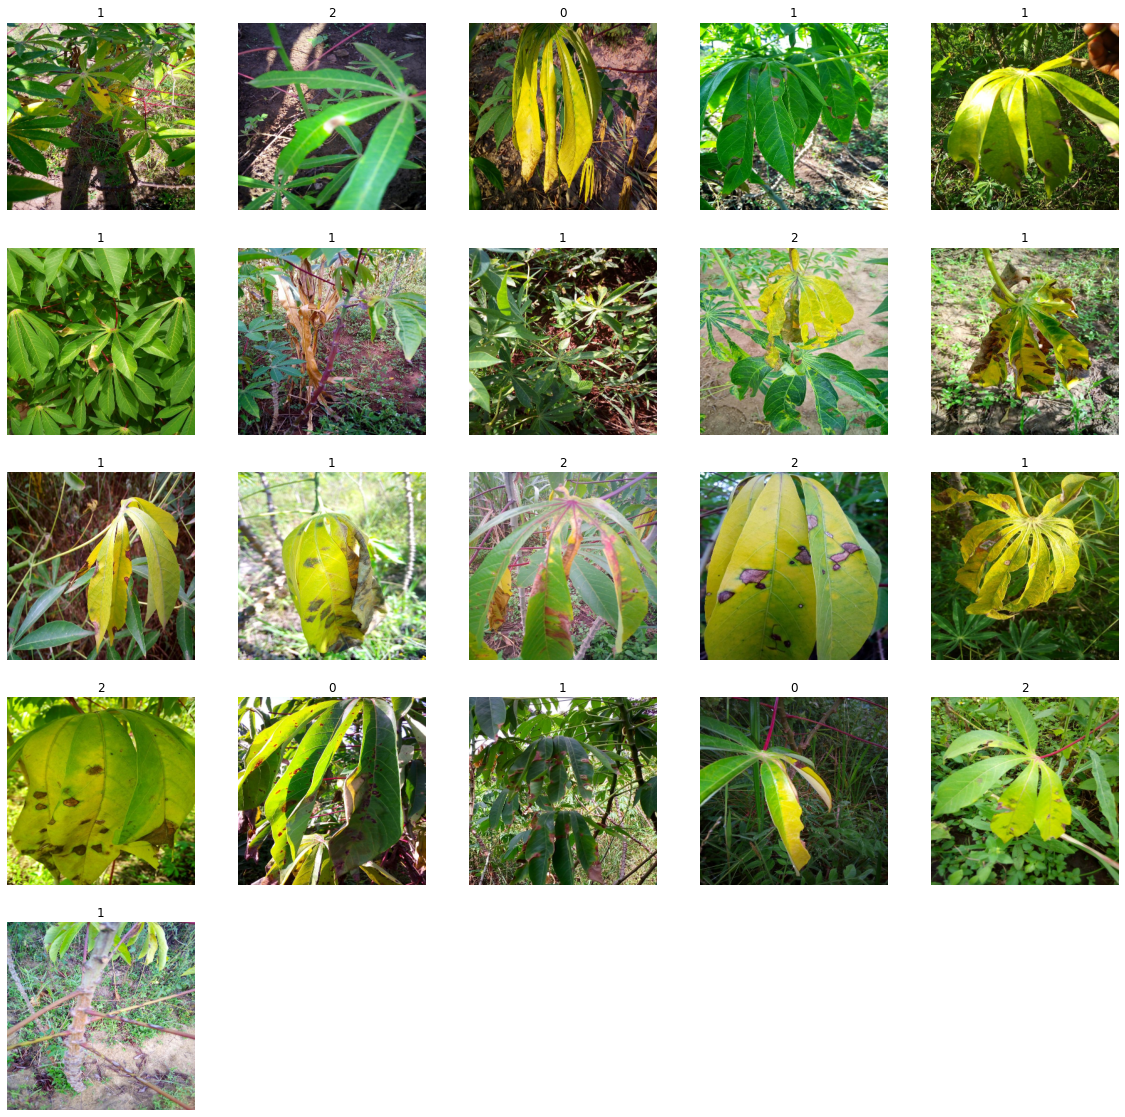

In [21]:
show = 0
plt.figure(figsize=(20,20))
for i,row in df.iterrows():
    if row['label']!=LABEL:
        continue

    img = imread(row['path'], resize=INPUT_SHAPE[:2])
    
    plt.subplot(20//5+1, 5, show+1)
    plt.imshow(img)
    plt.title(pred[i])
    plt.axis('off')
    show += 1
    
    if show>20:
        break